Reinforcement Learning Algorithm using DQN to beat GeoMania (game made by Niko Fotis)

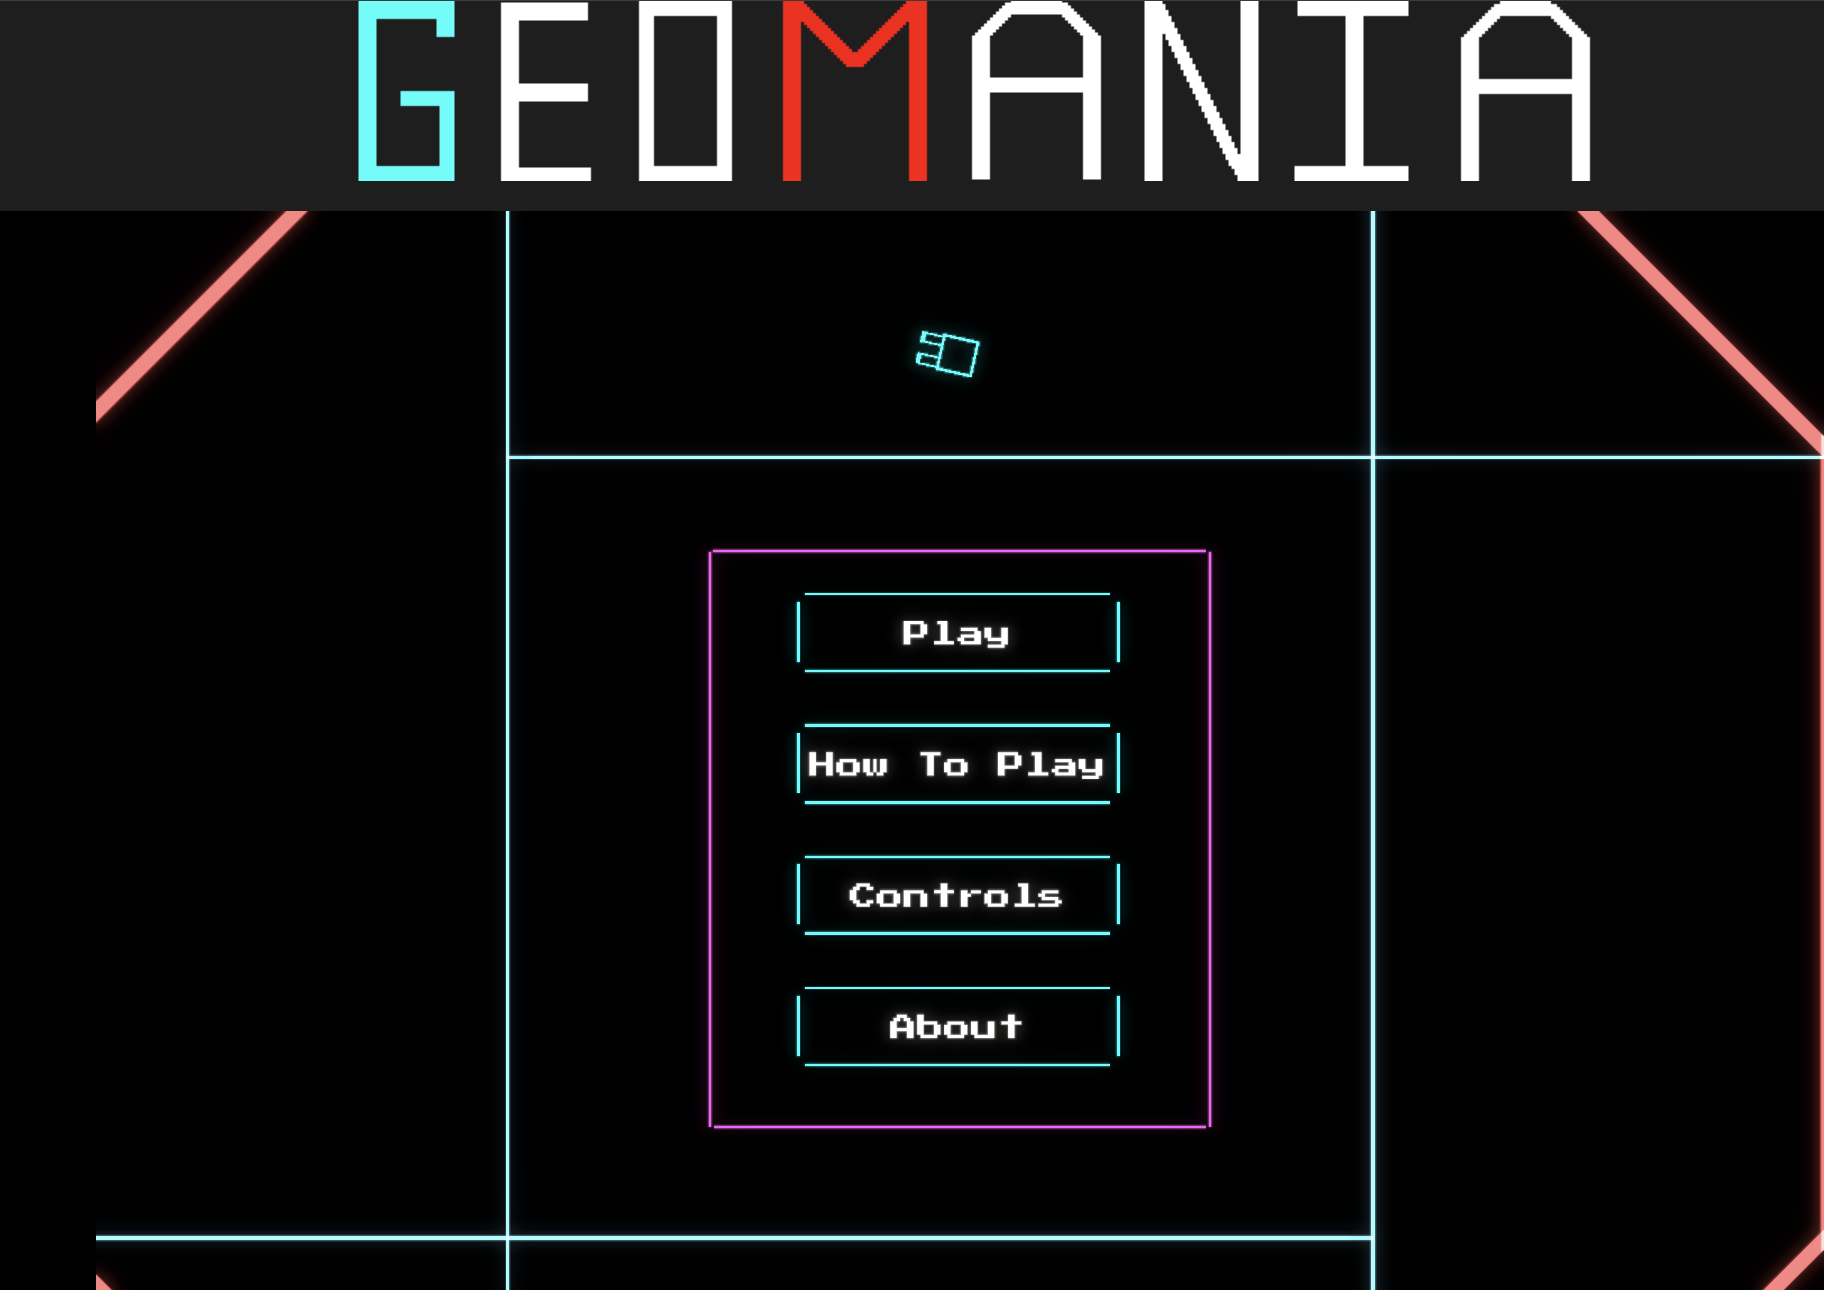

Geomania is a top-down arcade like twin-stick shooter that uses horde shooter mechanics to beat enemies, buy upgrades, and get to wave 20. There are mulitple components within the game that will be used in reinforcement algorithm to simulate a player.

To begin, we must highlight the intentded packages:

Image processesing: mss, openCV, systemOS (not sure)

Model Actions: OpenAI Gym library

Graphical representations: numpy, pyplot, pandas

Game: Goal is to use Itch.io release of the game on browser.


Methodology:

- Image processing:
    - Resolution size is fixed, meaning the player is centered to the screen the entire time. In theory, we can take small screen captures of the surrounding area, grayscale, and make decisions based on what is in teh capture. 
    - The shop: this is where you buy upgrades to make the player stronger, the shop moves based on key input (q and e) and has fixed box windows for each upgrade. This means we can store each of the upgrade in a key pair format and use openCV to tell the model where to click to purchase the upgrades. 
    - Money: As shown below, there is a reward menu that shows how much money is available, making use the model knows what is can buy will be important in the image pre processing. 
    - Next wave: same as the shop, it is a fixed box on the bottom right of the screen, allowing us to map the position in a key pair for model to click when finished.
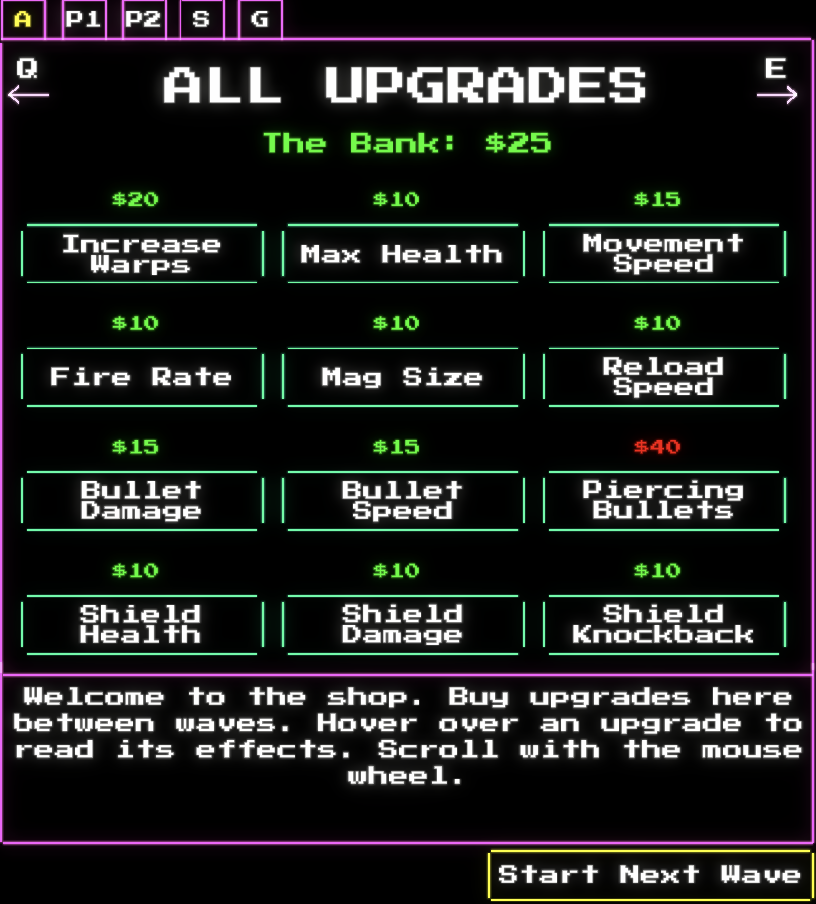
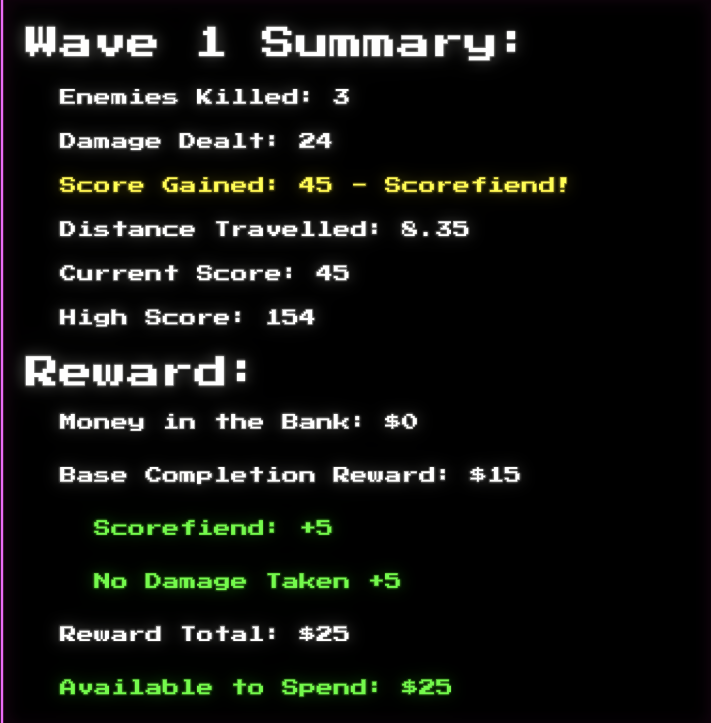
    - Game Over: The game over screen will need to be processes so the model knows when it needs to reset, there are also important variables in this screen that can be used for rewards, which will also need image processing to extract.
        
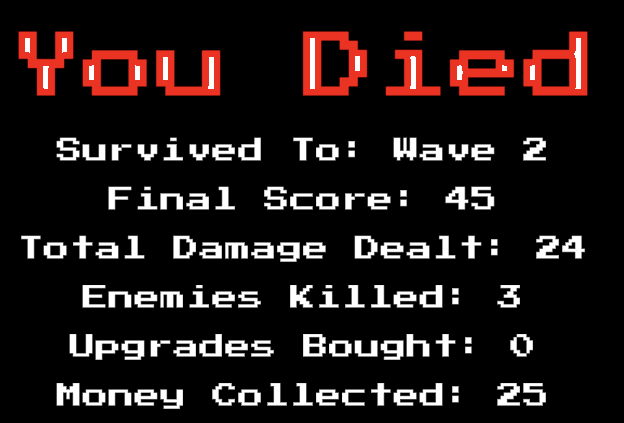

First we will discuss the dependencies and show the following installs

! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
Looking in indexes: https://download.pytorch.org/whl/cu126

This first install is for pytorch, which is the main model we will being with OpenAI gym library. 

Although not listed, my laptop has a nvidia 4060 GPU, which include CUDA 12.7, this will be used later on for optimization reasons

!pip3 install stable-baselines3[extra] protobuf==3.20.*

This next install is a reinforcement framework that will be used 

!pip3 install mss pydirectinput pytesseract

This install will do 2 things for us, allow us to take screen captures and relay python code into inputs to the computer, which allows the model to interact with the game

!pip3 install opencv-python

This is another image processing tool that will be used for the model

!pip3 install gym

This is OpenAI gym package that will be used for a majority of the environment set up in pre processing of the model

Now we can start writing some basic code to start reading in the game

In [2]:
from mss import mss # screen captures
import pydirectinput #inputs into computer
import cv2 # frame processing
import numpy as np # math library/multipurpose
import pytesseract # translate pictures into text, important for actions defined in environment
                   # for example, taking a capture of the game over screen, turning it into text -> making an action
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' #you may need to set this for your machine
from matplotlib import pyplot as plt
import time # allows us to buffer and pause model
from gym import Env
from gym import spaces
from gym.spaces import Box, Discrete


In [ ]:
class GeoManiaEnv(Env):

    def __init__(self):
        super().__init__()
        self.MAX_ENEMIES = 10
        self.observation_space = spaces.Dict({
            "image": spaces.Box(low=0,high=255,shape=(640, 480, 3), dtype=np.uint8), # here we are also going to assume only image data, we may need to increase the size of this later on
            "enemies": spaces.Sequence(spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32))  # Each enemy: (x, y)
    })# this will represent the enemies being observed
            
        self.action_space = spaces.MultiDiscrete([ #this more complex discrete map will allow us to create a more complex set of actions that a model will take. This is subject to change as time goes on
            5, # movement, this will include 5 actions: 0 = no move, 1 = up, 2 = down, 3 = left, 4 = right
            2, # shooting, which will include 3 actions: 0 = no_shoot, 1 = shoot
            #2, # store, which has 2 actions: buy, no_buy
            2, # grenade, which has 2 actions: grenade, no_grenade
            #2, # shield, which has 2 acition: shield, no_shield LATER WE WILL ADD THE REST IN
            ])
               # one thing to note is that mouse movement can be defined later on in the step function, as this is going to be a continuous action, defining it here could limit us later on
        self.capture = mss()

        self.player_capture = {'top':350, 'left':550, 'width':640, 'height':520}

        self.game_over_capture =  {'top':425, 'left':750, 'width':400, 'height':75}

        self.play_again_button =  {'top':725, 'left':525, 'width':400, 'height':75}
        

    def get_observation(self):
        raw_image =  np.array(self.capture.grab(self.player_capture))[:,:,:3] # raw image matrix of capture, with only 3 channels, as the 4th is not needed

        gray_scale = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY) #scaling to gray scale for binary color scheme

        resize = cv2.resize(gray_scale, (640,520))

        channel = np.reshape(resize, (1,520,640)) #stupid resize things for model later on i guess
        return channel
    
    def game_over(self):
        game_over_capture = np.array(self.capture.grab(self.game_over_capture))[:,:,:3] #same as before, but grabbing only the "You Died" text

        done = False
    
        gray_scale = cv2.cvtColor(game_over_capture, cv2.COLOR_BGR2GRAY) #Gray scale to improve Optical Character Recognition software

        cap = pytesseract.image_to_string(gray_scale)[:3] #grabbing only the word "You", as for some reaon it reads "You Died" as "Youd leop"

        if cap == "You":
            done = True

        return cap, gray_scale, done
    def play_again(self):
        play_again_capture = np.array(self.capture.grab(self.play_again_button))[:,:,:3]

        return play_again_capture
    
    def step(self, action):
         
        self.take_action(action)

        text, capture, done = self.game_over() # need to check if the game is over

        new_observation = self.get_observation() # grabbing next capture

        reward = 1
        
        info = {}

        return new_observation, reward, done, info
    def take_action(self, action):
        
        up, down, left, right, shooting = action #for now we will keep only move and shoot and add the rest later
        
        if up == 1:
            pydirectinput.keydown('w')
        elif down == 2:
            pydirectinput.keydown('s')
        elif left == 3:
            pydirectinput.keyDown('a')
        elif right == 4:
            pydirectinput.keydown('d')
        
        if shooting == 1:
            pydirectinput.click()

        time.sleep(0.05) #preliminary step to make sure there is slight delay between frames

        pydirectinput.keyUp('w') #to make sure the model doesnt keep holding it down, we may change this later
        pydirectinput.keyUp('s')
        pydirectinput.keyUp('a')
        pydirectinput.keyUp('d')

    def render(self):
        cv2.imshow('Game', np.array(self.capture.grab(self.player_capture))[:,:,:3])

    def close(self):
        cv2.destroyAllWindows()
    def reset(self):
        time.sleep(1)
        pydirectinput.moveTo(self.play_again_button['top'], self.play_again_button['left'] + 250)
    
    # Simulate the click (left mouse button)
        pydirectinput.click()

    # Optionally, wait for the game to reset or for a short delay
        time.sleep(1)
        return self.get_observation()
       
    
 


Now that we have some basic functionality with movement, we need to begin training an Object Detection Model, we decided to start with YOLO (You only look once). This popular library uses OpenCV to do calcualtions and return positions for the agent to use in aiming and dodging mechanics. There is more information in the note books labeled "generate_dataset" and "label_dataset", for a short recap we took screeshots of the game, used an application to label screenshots with enemys, turn it into metadata coordinates, trained the YOLO model, and tested the YOLO model as done below. 

In [ ]:
from YOLO_Object_Detection import *

window_name = "GeoMania by NIk_Fot - Google Chrome" #this may need to be adjusted as need be
cfg_file_name = r"C:\Users\brice\Downloads\yolo-opencv-detector-main\yolo-opencv-detector-main\yolov4-tiny\yolov4-tiny-custom.cfg" #give path to config file in folder
weights_file_name = r"C:\Users\brice\Downloads\yolo-opencv-detector-main\yolo-opencv-detector-main\yolov4-tiny-custom_last.weights" #this is the weight file from training

wincap = WindowCapture(window_name)
improc = ImageProcessor(wincap.get_window_size(), cfg_file_name, weights_file_name)

while(True):
    
    ss = wincap.get_screenshot()
    
    if cv.waitKey(1) == ord('q'):
        cv.destroyAllWindows()
        break

    coordinates = improc.proccess_image(ss)
    
    for coordinate in coordinates:
        print(coordinate)
    print()
    
    # If you have limited computer resources, consider adding a sleep delay between detections.
    # sleep(0.2)

print('Finished.')

There is a small limitation to this current implementation, it does not use OpenCVs CUDA capabilities, which may be smart to add later on to improve performance, or its also possible that using the GPU for only the agent is smart also, as object detection may not be a priority in the models success. 